error: 0.0157690818002
# of vertices: 7553


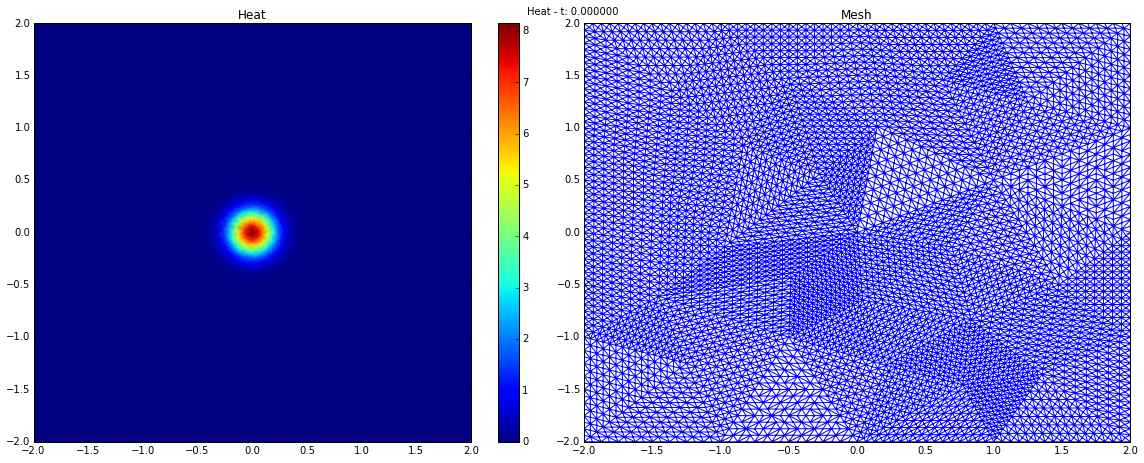

In [11]:
%matplotlib inline                                                                                                                                                                                                                                            
%run /home/fenics/fenics-matplotlib.py                                                                                                                                                                                                                        
from dolfin import *; 
from mshr import *; 
from IPython.display import display, clear_output; 
import time
import logging; logging.getLogger('FFC').setLevel(logging.WARNING)

# Generate domain and mesh
XMIN, XMAX = -2, 2; 
YMIN, YMAX = -2, 2; 
G = [XMIN, XMAX, YMIN, YMAX];
mresolution = 5;
mesh = generate_mesh(Rectangle(Point(G[0], G[2]), Point(G[1], G[3])), mresolution)

# Local and uniform mesh refinement 
def local_refine(mesh,center,r):
    xc, yc = center;
    cell_markers = MeshFunction("bool", mesh, mesh.topology().dim());
    for c in cells(mesh):
        mp = c.midpoint()
        cell_markers[c] = sqrt( (mp[0] - xc)*(mp[0] - xc) + (mp[1] - yc)*(mp[1] - yc))<r 
    mesh = refine(mesh, cell_markers)  
    return mesh;

r=0.4; xc, yc= 0.0, 0.0;
nrefinement  = 4
is_local_refine = 0
for i in range(0, nrefinement): # Refine mesh
    if is_local_refine:
        mesh = local_refine(mesh,[xc, yc], r)
    else:
        mesh = refine(mesh)

# Define heat kernel
t0 = 0.01
u = Expression("exp(-(x[0]*x[0]+x[1]*x[1])/(4*t))/(4*pi*t)", t=t0, domain=mesh, degree=3)

# Define finite element function space
degree=1
V = FunctionSpace(mesh, "CG", degree);

pl, ax = plt.subplots(); 
stepcounter = 0;

# Compact plot utility function
def plot_compact(u, t, stepcounter):
    if stepcounter % 5 == 0:
        uEuclidnorm = project(u, V); ax.cla(); fig = plt.gcf(); fig.set_size_inches(16, 6.5)
        plt.subplot(1, 2, 1); mplot_function(uEuclidnorm); plt.title("Heat") # Plot norm of velocity
        if t == 0.: plt.colorbar(); plt.axis(G)
        plt.subplot(1, 2, 2);
        if t == 0.: plt.triplot(mesh2triang(mesh)); plt.title("Mesh") # Plot mesh
        plt.suptitle("Heat - t: %f" % (t)); plt.tight_layout(); clear_output(wait=True); 

# Plot heat kernel u
plot_compact(u, 0, stepcounter)  

# Interpolate u onto V
Iu = interpolate(u, V)

# L1 error between two functions u1 and u2
def compute_error(u1, u2):
    mresolution_ref = 400;
    mesh_ref = RectangleMesh(Point(XMIN,YMIN), Point(XMAX, YMAX), mresolution_ref, mresolution_ref, "crossed")
    V_ref = FunctionSpace(mesh_ref, "CG", degree);
    Iu1 = interpolate(u1, V_ref)
    Iu2 = interpolate(u2, V_ref)
    error = assemble(abs(Iu1-Iu2)*dx)
    return error

# Compute error between u and its interpolant
error = compute_error(u, Iu)

print "error:", error
print "# of vertices:", mesh.num_vertices()